In [43]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.metrics import accuracy_score

### 1. Préparation des données

In [57]:
df_data = pd.read_csv('../data/train.csv')
df_data.head(1)

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.0,0.00293,0.00293,0.035156,0.0,0.0,0.004883,0.0,0.025391


In [58]:
X = df_data.copy().drop(['id', 'species'],axis='columns').values

species = df_data['species'].unique()

# Création des vecteurs one-hot pour la matrice de targets
t = np.zeros(df_data.shape[0])
for i in range(species.size):
    t[df_data['species'] == species[i]] = i

In [59]:
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.3, random_state=0)

In [60]:
#création des listes des valeurs d'hyper-paramètres possibles et choix du maximum d'itérations
all_values_lr = np.logspace(-9, 0, 10)
all_values_alpha = np.logspace(-9, 0, 10)
max_iter = 100000

### 2. Perceptron sans optimisation de paramètres

In [48]:
alpha = 0.001
learning_rate = 0.001

# création d'un classifieur binaire pour chaque classe
classifieur = Perceptron(alpha=alpha, max_iter=max_iter, eta0=learning_rate)    
classifieur.fit(X_train, t_train)

Perceptron(alpha=0.001, eta0=0.001, max_iter=100000)

In [49]:
print("Score X_train, t_train : {:.2f}%".format(classifieur.score(X_train, t_train)*100))
print("Score X_test, t_test : {:.2f}%".format(classifieur.score(X_test, t_test)*100))

Score X_train, t_train : 45.02%
Score X_test, t_test : 31.65%


### 3. Perceptron sans optimisation de paramètres avec une pénalité L2

In [52]:
alpha = 0.001
learning_rate = 0.001

# création d'un classifieur binaire pour chaque classe
classifieur_reg = Perceptron(penalty='l2', alpha=alpha, max_iter=max_iter, eta0=learning_rate)    
classifieur_reg.fit(X_train, t_train)

Perceptron(alpha=0.001, eta0=0.001, max_iter=100000, penalty='l2')

In [53]:
print("Score X_train, t_train : {:.2f}%".format(classifieur_reg.score(X_train, t_train)*100))
print("Score X_test, t_test : {:.2f}%".format(classifieur_reg.score(X_test, t_test)*100))

Score X_train, t_train : 45.17%
Score X_test, t_test : 31.99%


### 4. Perceptron avec optimisation des paramètres

In [83]:
# Paramètre à tester
param_grid_perceptron = {
    'eta0' : all_values_lr,
    'alpha' : all_values_alpha
}

# Création du modèle de recherche sur grille
grid_search_perceptron = GridSearchCV(Perceptron(penalty='l2', max_iter=max_iter), param_grid_perceptron, cv=5, verbose=3, n_jobs=-1)

# Entraînement du modèle avec la recherche sur grille
grid_search_perceptron.fit(X_train, t_train)
print('Done')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\adcol\anaconda3\envs\ta_env\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Done


In [84]:
results_grid_perceptron = pd.DataFrame.from_dict(grid_search_perceptron.cv_results_)
print(results_grid_perceptron)

    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0        0.187100      0.018961         0.001595    4.886947e-04         0.0   
1        0.186302      0.016561         0.001198    3.976913e-04         0.0   
2        0.227791      0.038081         0.002393    1.016682e-03         0.0   
3        0.256112      0.048110         0.002194    1.465220e-03         0.0   
4        0.231980      0.050707         0.001994    1.545141e-03         0.0   
..            ...           ...              ...             ...         ...   
95       0.216820      0.022091         0.001596    4.879746e-04         1.0   
96       0.252524      0.058309         0.001397    4.878979e-04         1.0   
97       0.231780      0.033570         0.001995    7.478899e-07         1.0   
98       0.227193      0.039186         0.001795    7.456393e-04         1.0   
99       0.320342      0.039216         0.001795    7.467735e-04         1.0   

   param_eta0                          

In [98]:
# Meilleurs paramètres et meilleure précision
print("Meilleur paramètre:", grid_search_perceptron.best_params_)
print("Meilleure précision sur un split : {:.2f}%".format(grid_search_perceptron.best_score_*100))
print("Score X_train, t_train : {:.2f}%".format(grid_search_perceptron.score(X_train, t_train)*100))

Meilleur paramètre: {'alpha': 1e-05, 'eta0': 1.0}
Meilleure précision sur un split : 65.77%
Score X_train, t_train : 89.47%


### 5. Visualisation de l'évolution de notre score selon l'évolution de nos hyper-paramètres

In [86]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1, figsize = (8,6))

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.semilogx(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=10, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=10)
    ax.set_ylabel('CV Average Score', fontsize=10)
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=8)
    ax.grid('on') 


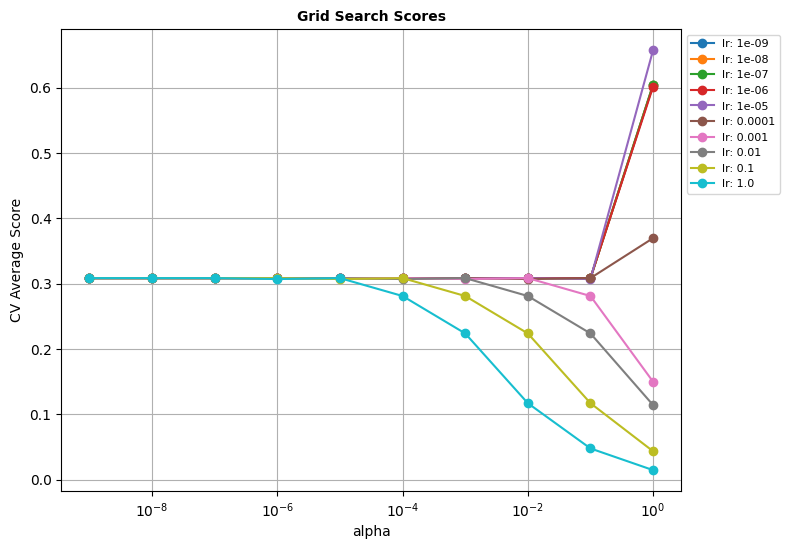

In [87]:
plot_grid_search(results_grid_perceptron, all_values_alpha, all_values_lr, 'alpha', 'lr')
# on voit qu'il y a pas grand changement a 10-5 donc on devrait concentrer les paraam

### 6. Test du perceptron sur nos données test

In [100]:
print("Score X_test, t_test : {:.2f}%".format(grid_search_perceptron.score(X_test, t_test)*100))

Score X_test, t_test : 68.35%


### 7. Utilisation de notre perceptron en isolant chaque features : Margin / Shape / Textures

### 7.1 Préparation des données

In [123]:
# direct k-fold 
#comparaison entre le global et chaque features une a une 
X_margin = df_data.iloc[:, 2:66].values
X_shape = df_data.iloc[:, 66:130].values
X_texture = df_data.iloc[:, 130:].values

In [124]:
X_train_margin, X_test_margin, t_train_margin, t_test_margin = train_test_split(X_margin, t, test_size=0.3, random_state=0)

In [125]:
X_train_shape, X_test_shape, t_train_shape, t_test_shape = train_test_split(X_shape, t, test_size=0.3, random_state=0)

In [126]:
X_train_texture, X_test_texture, t_train_texture, t_test_texture = train_test_split(X_texture, t, test_size=0.3, random_state=0)

### 7.2 Recherche du meilleur modèle pour chaque feature
### 7.2.1 Margin :

In [127]:
# Paramètre à tester
param_grid_perceptron = {
    'eta0' : all_values_lr,
    'alpha' : all_values_alpha
}

# Création du modèle de recherche sur grille
perceptron_margin = GridSearchCV(Perceptron(penalty='l2', max_iter=max_iter), param_grid_perceptron, cv=5, verbose=3, n_jobs=-1)

# Entraînement du modèle avec la recherche sur grille
perceptron_margin.fit(X_train_margin, t_train_margin)
print('Done')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\adcol\anaconda3\envs\ta_env\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Done


In [128]:
# Meilleurs paramètres et meilleure précision
print("Meilleur paramètre:", perceptron_margin.best_params_)
print("Meilleure précision sur un split : {:.2f}%".format(perceptron_margin.best_score_*100))
print("Score X_train, t_train : {:.2f}%".format(perceptron_margin.score(X_train_margin, t_train_margin)*100))
print("Score X_test, t_test : {:.2f}%".format(perceptron_margin.score(X_test_margin, t_test_margin)*100))

Meilleur paramètre: {'alpha': 1e-06, 'eta0': 1.0}
Meilleure précision sur un split : 10.24%
Score X_train, t_train : 17.17%
Score X_test, t_test : 8.42%


### 7.2.2 Shape : 

In [129]:
# Paramètre à tester
param_grid_perceptron = {
    'eta0' : all_values_lr,
    'alpha' : all_values_alpha
}

# Création du modèle de recherche sur grille
perceptron_shape = GridSearchCV(Perceptron(penalty='l2', max_iter=max_iter), param_grid_perceptron, cv=5, verbose=3, n_jobs=-1)

# Entraînement du modèle avec la recherche sur grille
perceptron_shape.fit(X_train_shape, t_train_shape)
print('Done')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\adcol\anaconda3\envs\ta_env\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Done


In [130]:
# Meilleurs paramètres et meilleure précision
print("Meilleur paramètre:", perceptron_shape.best_params_)
print("Meilleure précision sur un split : {:.2f}%".format(perceptron_shape.best_score_*100))
print("Score X_train, t_train : {:.2f}%".format(perceptron_shape.score(X_train_shape, t_train_shape)*100))
print("Score X_test, t_test : {:.2f}%".format(perceptron_shape.score(X_test_shape, t_test_shape)*100))

Meilleur paramètre: {'alpha': 0.001, 'eta0': 1.0}
Meilleure précision sur un split : 1.73%
Score X_train, t_train : 2.31%
Score X_test, t_test : 1.01%


### 7.2.3 Texture : 

In [131]:
# Paramètre à tester
param_grid_perceptron = {
    'eta0' : all_values_lr,
    'alpha' : all_values_alpha
}

# Création du modèle de recherche sur grille
perceptron_texture = GridSearchCV(Perceptron(penalty='l2', max_iter=max_iter), param_grid_perceptron, cv=5, verbose=3, n_jobs=-1)

# Entraînement du modèle avec la recherche sur grille
perceptron_texture.fit(X_train_texture, t_train_texture)
print('Done')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\adcol\anaconda3\envs\ta_env\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Done


In [132]:
# Meilleurs paramètres et meilleure précision
print("Meilleur paramètre:", perceptron_texture.best_params_)
print("Meilleure précision sur un split : {:.2f}%".format(perceptron_texture.best_score_*100))
print("Score X_train, t_train : {:.2f}%".format(perceptron_texture.score(X_train_texture, t_train_texture)*100))
print("Score X_test, t_test : {:.2f}%".format(perceptron_texture.score(X_test_texture, t_test_texture)*100))

Meilleur paramètre: {'alpha': 1e-05, 'eta0': 1.0}
Meilleure précision sur un split : 24.25%
Score X_train, t_train : 30.30%
Score X_test, t_test : 18.86%
